In [1]:
# Configuración inicial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import beta
from datetime import datetime
import matplotlib.ticker as ticker
#Fecha inicial
periodo_inicial = datetime(2022, 10, 1)
# Semilla aleatoria
seed = 44
random.seed(seed)
np.random.seed(seed)

In [2]:
## Parámetros de Venta
### Parámetros de excenarios de Venta
#Periodos de inicio y terminación de venta
Periodo_Minimo_Venta = 3
Periodo_Maximo_Venta = 34
#PLAZOS  DE CRÉDITO
enganche = 0.05
meses_finiquito = 8

### Inventario de Venta
#Parámetros de Venta Individual
catalogo_venta = {
    "Pinar": {
        "# de unidades": 64,
        "Tamaño m2": 72.9,
        "Precio Base x m2": 20048,
        "Costo de Construcción m2": 7674,
        "Meses Construcción": 7
    },
    "Olmo": {
        "# de unidades": 105,
        "Tamaño m2": 85.0,
        "Precio Base x m2": 20260,
        "Costo de Construcción m2": 7820,
        "Meses Construcción": 7
    },
    "Mezquite": {
        "# de unidades": 71,
        "Tamaño m2": 100.0,
        "Precio Base x m2": 19889,
        "Costo de Construcción m2": 7674,
        "Meses Construcción": 7
    }
}
# Número total de unidades
total_unidades = sum(item["# de unidades"] for item in catalogo_venta.values())
# Convertir cada entrada en un DataFrame y añadir la columna "Precio de Venta"
inventario = {}
for key, value in catalogo_venta.items():
    df = pd.DataFrame([value])
    df['Precio de Venta'] = df['Tamaño m2'] * df['Precio Base x m2']
    df['Costo de Construcción'] = df['Tamaño m2'] * df['Costo de Construcción m2']
    inventario[key] = df

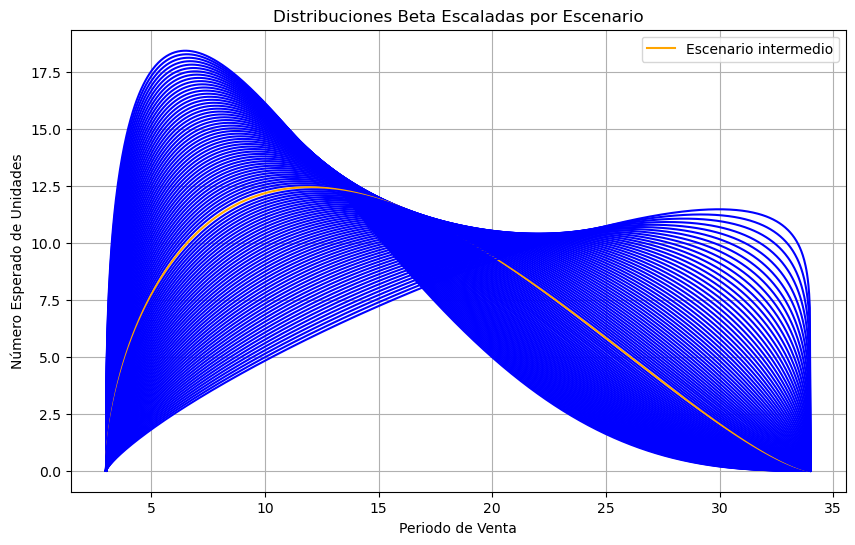

In [3]:
#Escenarios de distribución de ventas
Escenarios_Periodos = 100
Alfa_Periodos_Optimista = 1.35
Beta_Periodos_Optimista = 3.76
Alfa_Periodos_Pesimista = 1.8
Beta_Periodos_Pesimista = 1.12
# Elegir el escenario intermedio o uno elegido
escenario_unico = Escenarios_Periodos // 2 # Índice intermedio (redondeado hacia arriba)
#escenario_unico = 0
# Generar valores interpolados para Alfa y Beta
Alfa_Periodos_escenarios = np.linspace(Alfa_Periodos_Optimista, Alfa_Periodos_Pesimista, Escenarios_Periodos)
Beta_Periodos_escenarios = np.linspace(Beta_Periodos_Optimista, Beta_Periodos_Pesimista, Escenarios_Periodos)

## Simulación heterogénea de escenarios
# Preparar la gráfica
plt.figure(figsize=(10, 6))

# Iterar sobre los valores de Alfa y Beta para cada escenario
for i in range(Escenarios_Periodos):
    alfa = Alfa_Periodos_escenarios[i]
    beta_param = Beta_Periodos_escenarios[i]
    
    # Generar valores para la distribución Beta
    x = np.linspace(0, 1, 1000)
    y = beta.pdf(x, alfa, beta_param)
    
    # Escalar la distribución Beta al rango [Periodo_Minimo_Venta, Periodo_Maximo_Venta]
    x_scaled = Periodo_Minimo_Venta + x * (Periodo_Maximo_Venta - Periodo_Minimo_Venta)
    
    # Ajustar la densidad para que represente el número esperado de unidades
    y_scaled = y * total_unidades / (Periodo_Maximo_Venta - Periodo_Minimo_Venta) # Multiplicar por el rango del periodo

    # Determinar el color de la línea
    color = 'orange' if i == escenario_unico else 'blue'
    label = 'Escenario intermedio' if i == escenario_unico else ''

    # Graficar la distribución escalada
    plt.plot(x_scaled, y_scaled, color=color, label=label)

# Añadir título y etiquetas
plt.title('Distribuciones Beta Escaladas por Escenario')
plt.xlabel('Periodo de Venta')
plt.ylabel('Número Esperado de Unidades')
plt.grid(True)
plt.legend()
plt.show()

In [4]:
# Modelado
## Proyección de Ventas
### Proyección de todos los escenarios de Venta
# Crear el DataFrame 'Ventas'
ventas_data = []

for tipo_unidad, df in inventario.items():
    num_unidades = int(df.iloc[0]['# de unidades'])
    precio_venta = df.iloc[0]['Precio de Venta']
    
    for i in range(Escenarios_Periodos):
        alfa = Alfa_Periodos_escenarios[i]
        beta = Beta_Periodos_escenarios[i]
        escenario_label = i+1
        
        # Generar valores aleatorios siguiendo una distribución Beta
        beta_distribution = np.random.beta(alfa, beta, num_unidades)
        
        # Escalar la distribución Beta para que esté en el rango [Periodo_Minimo_Venta, Periodo_Maximo_Venta]
        periodos_de_venta = Periodo_Minimo_Venta + beta_distribution * (Periodo_Maximo_Venta - Periodo_Minimo_Venta)
        periodos_de_venta = periodos_de_venta.round().astype(int)
        
        # Extender datos con escenario incluido
        for j in range(num_unidades):
            ventas_data.append([tipo_unidad, precio_venta, periodos_de_venta[j], escenario_label])

# Crear el DataFrame final
ventas_escenarios = pd.DataFrame(ventas_data, columns=['Tipo de Unidad', 'Precio de Venta', 'Periodo_de_Venta', 'Escenario'])

ventas_escenarios

,Tipo de Unidad,Precio de Venta,Periodo_de_Venta,Escenario
0,Pinar,1461499.2,5,1
1,Pinar,1461499.2,6,1
2,Pinar,1461499.2,8,1
3,Pinar,1461499.2,4,1
4,Pinar,1461499.2,17,1
...,...,...,...,...
23995,Mezquite,1988900.0,27,100
23996,Mezquite,1988900.0,8,100
23997,Mezquite,1988900.0,24,100
23998,Mezquite,1988900.0,32,100


In [5]:
#### Ingresos por venta
# Crear una copia del DataFrame original
ingresos_venta = ventas_escenarios.copy()

# Multiplicar la columna 'Precio de Venta' por plazos y cambio de nombre columna
ingresos_venta['Ingresos por Venta'] = ingresos_venta['Precio de Venta'] * enganche
ingresos_venta.drop(columns=['Precio de Venta'], inplace=True)
ingresos_venta['Periodo'] = ingresos_venta['Periodo_de_Venta']
ingresos_venta.drop(columns=['Periodo_de_Venta'], inplace=True)
ingresos_venta_duplicado = ingresos_venta.copy()
ingresos_venta_duplicado['Periodo'] += meses_finiquito
ingresos_venta_duplicado['Ingresos por Venta'] /= (enganche / (1 - enganche))
ingresos_venta = pd.concat([ingresos_venta, ingresos_venta_duplicado], ignore_index=True)

ingresos_venta

,Tipo de Unidad,Escenario,Ingresos por Venta,Periodo
0,Pinar,1,73074.96,5
1,Pinar,1,73074.96,6
2,Pinar,1,73074.96,8
3,Pinar,1,73074.96,4
4,Pinar,1,73074.96,17
...,...,...,...,...
47995,Mezquite,100,1889455.00,35
47996,Mezquite,100,1889455.00,16
47997,Mezquite,100,1889455.00,32
47998,Mezquite,100,1889455.00,40


In [6]:
# Agrupar por 'Periodo' y 'Tipo de Unidad', luego sumar los 'Ingresos por Venta'
ingresos_agrupados = ingresos_venta.groupby(['Escenario', 'Periodo'])['Ingresos por Venta'].sum().reset_index()
ingresos_agrupados

,Escenario,Periodo,Ingresos por Venta
0,1,3,219224.88
1,1,4,1047529.88
2,1,5,1624204.80
3,1,6,2108089.80
4,1,7,1451994.80
...,...,...,...
3647,100,38,14234702.72
3648,100,39,20778682.72
3649,100,40,18013612.72
3650,100,41,25317972.72


In [7]:
### Proyección de 1 Escenario de Ventas

In [8]:
# Obtener los valores de Alfa y Beta para el escenario intermedio
alfa_intermedio = Alfa_Periodos_escenarios[escenario_unico]
beta_intermedio = Beta_Periodos_escenarios[escenario_unico]

# Crear el DataFrame 'Ventas'
ventas_data = []

for tipo_unidad, df in inventario.items():
    num_unidades = int(df.iloc[0]['# de unidades'])
    precio_venta = df.iloc[0]['Precio de Venta']
    ventas_data.extend([[tipo_unidad, precio_venta]] * num_unidades)

ventas_un_escenario = pd.DataFrame(ventas_data, columns=['Tipo de Unidad', 'Precio de Venta'])

# Generar valores aleatorios siguiendo una distribución Beta con el escenario intermedio
beta_distribution = np.random.beta(alfa_intermedio, beta_intermedio, total_unidades)

# Escalar la distribución Beta para que esté en el rango [Periodo_Minimo_Venta, Periodo_Maximo_Venta]
ventas_un_escenario['Periodo_de_Venta'] = Periodo_Minimo_Venta + beta_distribution * (Periodo_Maximo_Venta - Periodo_Minimo_Venta)

# Redondear los periodos de venta al entero más cercano
ventas_un_escenario['Periodo_de_Venta'] = ventas_un_escenario['Periodo_de_Venta'].round().astype(int)
ventas_un_escenario['Escenario'] = escenario_unico + 1

ventas_un_escenario

,Tipo de Unidad,Precio de Venta,Periodo_de_Venta,Escenario
0,Pinar,1461499.2,17,51
1,Pinar,1461499.2,12,51
2,Pinar,1461499.2,17,51
3,Pinar,1461499.2,17,51
4,Pinar,1461499.2,8,51
...,...,...,...,...
235,Mezquite,1988900.0,8,51
236,Mezquite,1988900.0,12,51
237,Mezquite,1988900.0,14,51
238,Mezquite,1988900.0,15,51


In [9]:
#### Ingresos de venta 1 escenario

In [10]:
# Crear una copia del DataFrame original
ingresos_venta_un_escenario = ventas_un_escenario.copy()

# Multiplicar la columna 'Precio de Venta' por plazos y cambio de nombre columna
ingresos_venta_un_escenario['Ingresos por Venta'] = ingresos_venta_un_escenario['Precio de Venta'] * enganche
ingresos_venta_un_escenario.drop(columns=['Precio de Venta'], inplace=True)
ingresos_venta_un_escenario['Periodo'] = ingresos_venta_un_escenario['Periodo_de_Venta']
ingresos_venta_un_escenario.drop(columns=['Periodo_de_Venta'], inplace=True)
ingresos_venta_duplicado = ingresos_venta_un_escenario.copy()
ingresos_venta_duplicado['Periodo'] += meses_finiquito
ingresos_venta_duplicado['Ingresos por Venta'] /= (enganche / (1 - enganche))
ingresos_venta_un_escenario = pd.concat([ingresos_venta_un_escenario, ingresos_venta_duplicado], ignore_index=True)

ingresos_venta_un_escenario

,Tipo de Unidad,Escenario,Ingresos por Venta,Periodo
0,Pinar,51,73074.96,17
1,Pinar,51,73074.96,12
2,Pinar,51,73074.96,17
3,Pinar,51,73074.96,17
4,Pinar,51,73074.96,8
...,...,...,...,...
475,Mezquite,51,1889455.00,16
476,Mezquite,51,1889455.00,20
477,Mezquite,51,1889455.00,22
478,Mezquite,51,1889455.00,23


In [11]:
# Agrupar por 'Periodo_de_Venta' y sumar los 'Ingresos por Venta'
ingresos_agrupados_un_escenario = ingresos_venta_un_escenario.groupby('Periodo')['Ingresos por Venta'].sum().reset_index()
ingresos_agrupados_un_escenario

,Periodo,Ingresos por Venta
0,3,86105.00
1,4,702799.92
2,5,801934.96
3,6,444484.92
4,7,815274.96
5,8,788594.96
6,9,755540.00
7,10,788904.92
8,11,2226009.92
9,12,14414068.36


In [12]:
# Crear un diccionario de DataFrames con sus nombres
dataframes = {'ventas_un_escenario' : ventas_un_escenario, 'ingresos_venta_un_escenario' : ingresos_venta_un_escenario, 'ingresos_agrupados_un_escenario' : ingresos_agrupados_un_escenario}

# Crear o abrir un archivo Excel y agregar múltiples hojas
with pd.ExcelWriter('flujo_financiero_excel.xlsx', engine='xlsxwriter') as writer:
    for df_name, df in dataframes.items():
        df.to_excel(writer, sheet_name=df_name)

In [13]:
## Proyección de Costos

In [14]:
### Parámetros Costos

In [15]:
porcentaje_terreno = -0.11
porcentaje_supervision_indirectos = -0.015
porcentaje_contingencias = -0.03
porcentaje_cuota_desarrollo = -0.0696
porcentaje_comision_venta = -0.0464

In [16]:
### Costos Escenarios

In [17]:
#### Costos de Terreno Todos los Escenarios

In [18]:
# Crear una copia del DataFrame original
Costo_Tierra = ingresos_agrupados.copy()

# Multiplicar la columna 'Precio de Venta' por plazos y cambio de nombre columna
Costo_Tierra['Pago de Tierra'] = Costo_Tierra['Ingresos por Venta'] * porcentaje_terreno
Costo_Tierra.drop(columns=['Ingresos por Venta'], inplace=True)

Costo_Tierra

,Escenario,Periodo,Pago de Tierra
0,1,3,-2.411474e+04
1,1,4,-1.152283e+05
2,1,5,-1.786625e+05
3,1,6,-2.318899e+05
4,1,7,-1.597194e+05
...,...,...,...
3647,100,38,-1.565817e+06
3648,100,39,-2.285655e+06
3649,100,40,-1.981497e+06
3650,100,41,-2.784977e+06


In [19]:
### Costos 1 Escenario

In [20]:
#### Costos de Terreno 1 Escenario

In [21]:
# Crear una copia del DataFrame original
Costo_Tierra_un_escenario = ingresos_agrupados_un_escenario.copy()

# Multiplicar la columna 'Precio de Venta' por plazos y cambio de nombre columna
Costo_Tierra_un_escenario['Pago de Tierra'] = Costo_Tierra_un_escenario['Ingresos por Venta'] * porcentaje_terreno
Costo_Tierra_un_escenario.drop(columns=['Ingresos por Venta'], inplace=True)

Costo_Tierra_un_escenario

,Periodo,Pago de Tierra
0,3,-9.471550e+03
1,4,-7.730799e+04
2,5,-8.821285e+04
3,6,-4.889334e+04
4,7,-8.968025e+04
5,8,-8.674545e+04
6,9,-8.310940e+04
7,10,-8.677954e+04
8,11,-2.448611e+05
9,12,-1.585548e+06


In [22]:
# Visualización

In [23]:
## Visualización de 1 escenario

In [24]:
### Visualización de Ventas

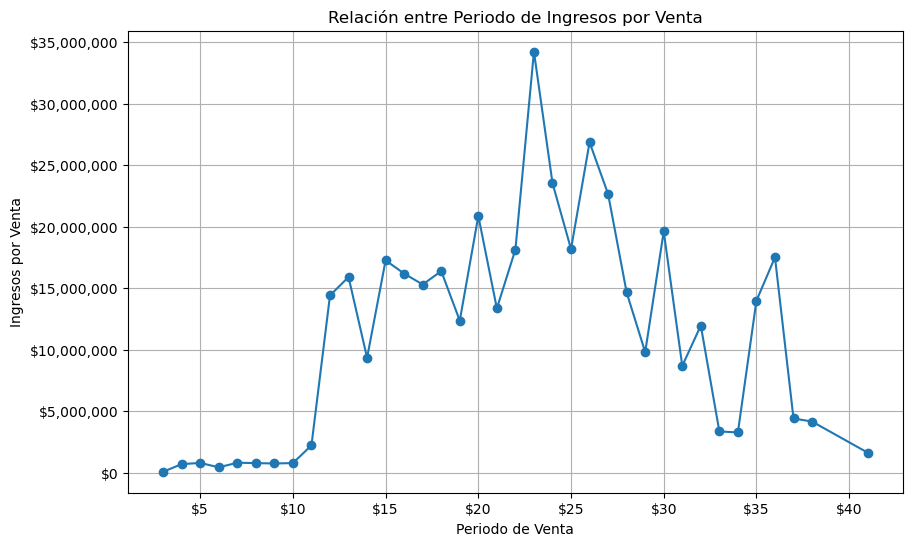

In [25]:
# Función para formatear los valores en formato $#,##0.00
def format_to_currency(x, pos):
    return f'${x:,.0f}'

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(ingresos_agrupados_un_escenario['Periodo'], ingresos_agrupados_un_escenario['Ingresos por Venta'], marker='o', linestyle='-')

# Añadir título y etiquetas
plt.title('Relación entre Periodo de Ingresos por Venta')
plt.xlabel('Periodo de Venta')
plt.ylabel('Ingresos por Venta')

# Aplicar el formato a los ejes x y y
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_to_currency))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_to_currency))

# Añadir cuadrícula
plt.grid(True)

# Mostrar la gráfica
plt.show()

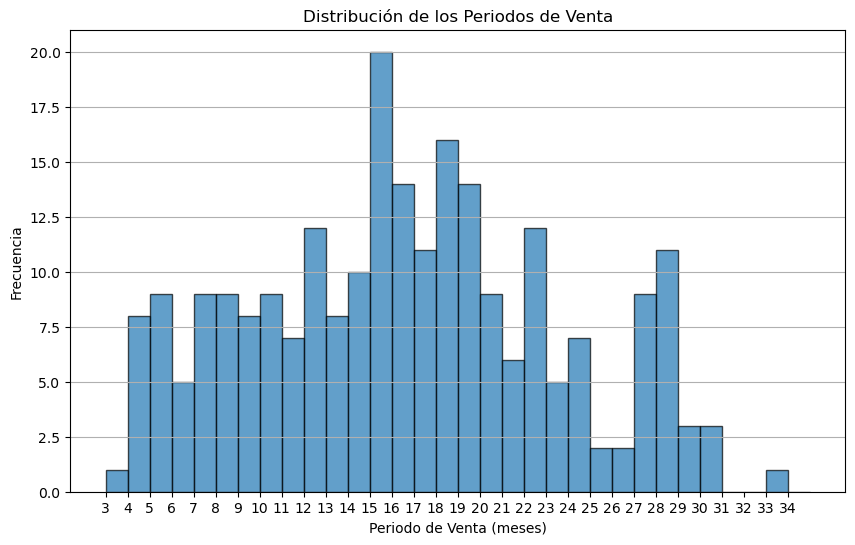

In [26]:
# Graficar un histograma de la columna 'Periodo_de_Venta'
plt.figure(figsize=(10, 6))
plt.hist(ventas_un_escenario['Periodo_de_Venta'], bins=range(Periodo_Minimo_Venta, Periodo_Maximo_Venta + 2), edgecolor='black', alpha=0.7)
plt.title('Distribución de los Periodos de Venta')
plt.xlabel('Periodo de Venta (meses)')
plt.ylabel('Frecuencia')
plt.xticks(range(Periodo_Minimo_Venta, Periodo_Maximo_Venta + 1))
plt.grid(axis='y')

# Mostrar la gráfica
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


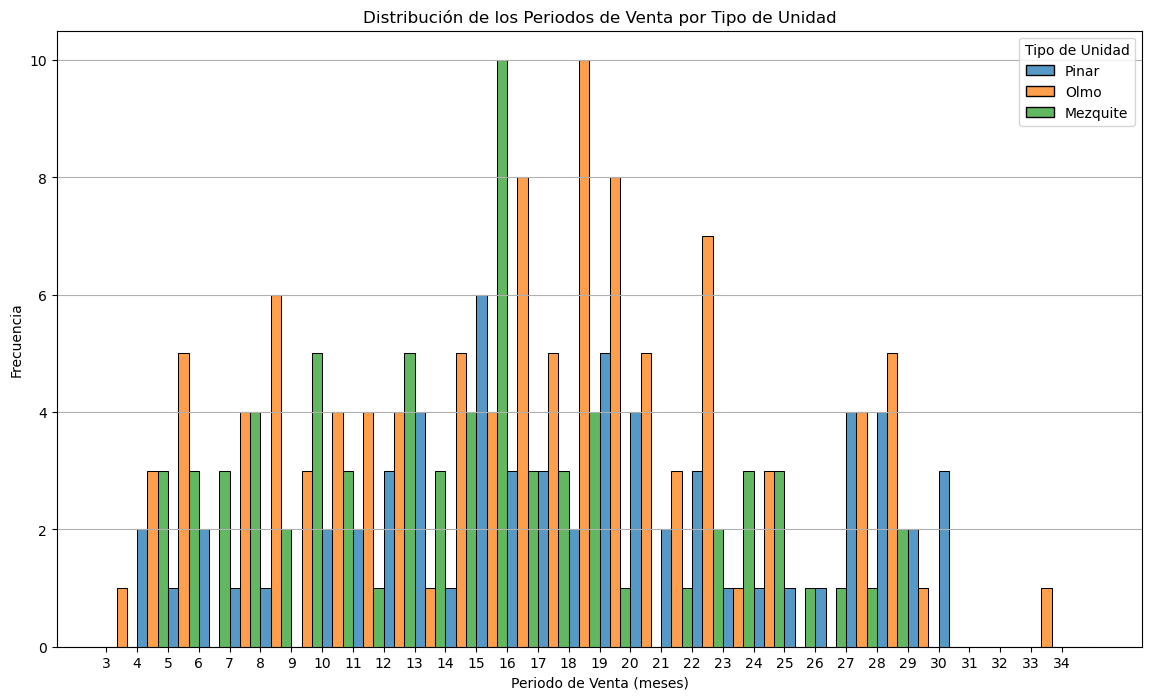

In [27]:
# Configurar el tamaño de la figura
plt.figure(figsize=(14, 8))

# Crear un gráfico de barras agrupadas
sns.histplot(data=ventas_un_escenario, x='Periodo_de_Venta', hue='Tipo de Unidad', multiple='dodge', 
             bins=range(Periodo_Minimo_Venta, Periodo_Maximo_Venta + 2), edgecolor='black')

plt.title('Distribución de los Periodos de Venta por Tipo de Unidad')
plt.xlabel('Periodo de Venta (meses)')
plt.ylabel('Frecuencia')
plt.xticks(range(Periodo_Minimo_Venta, Periodo_Maximo_Venta + 1))
plt.grid(axis='y')

# Mostrar la gráfica
plt.show()